Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


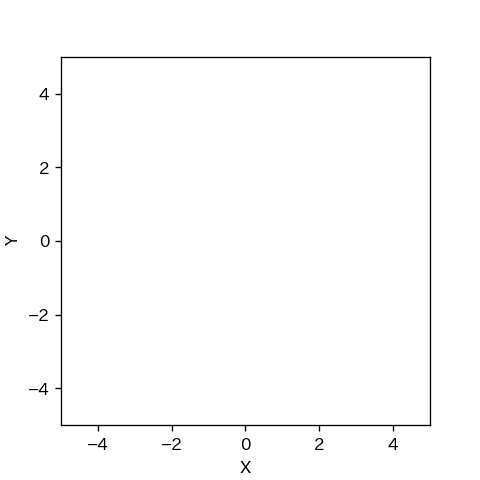

In [1]:
import sys
sys.path.append("../scripts/")
import matplotlib.animation as anm
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    #world.ani.save()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


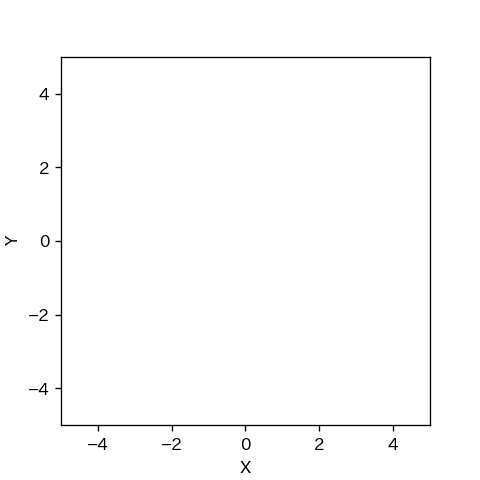

(array([ 3.94673179, -1.41253819, -2.3814842 ]),
 array([ 4.94296871, -1.96686774, -0.81419918]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[4.608978114638492]
0 真値: [ 2.45793733 -4.22491354  6.40655246] 推定値: [-2.11623724  4.6976025   6.08692654] 誤差: 10.02668267410959
[2.1941592801757275]
1 真値: [0.96335977 3.26172063 5.45302857] 推定値: [ 4.13274918  4.74948397 -2.83511639] 誤差: 3.501209648406164
[2.474588599831221]
[6.120152354738039, 1.30381262606693]
2 真値: [3.25398594 0.86236963 4.82214099] 推定値: [3.16060116 0.85810213 4.90252408] 誤差: 0.09348223939009416
1
[6.06727723909232]
[7.050189612624152]
3 真値: [-3.68326588  0.86948591  5.20500314] 推定値: [-3.39088017  1.04014083  5.36458308] 誤差: 0.3385446844495172
2
[0.9692410694142253]
4 真値: [-5.20727996  3.57310287  4.91811821] 推定値: [-1.92982632  1.81846405  8.79237572] 誤差: 3.7175878866858394
[4.598699748535093]
[2.267707839506689, 2.9412717430361432]
[2.8136290805189486, 2.701513706770216]
[2.7968821268369055, 3.2218292835670885]
5 真値: [ 3.62713042 -1.02061497  3.9667357 ] 推定値: [ 2.82837691 -1.00033736  4.2465199 ] 誤差: 0.7990108524145157
3
6 真値: [-4.75831618  3.19983103  6.25653066] 

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[2.9716117603499703]
[2.418441071297089, 6.036123861126874]
20 真値: [-1.65693355 -0.99819019  4.51488562] 推定値: [-2.04740511 -1.31867618  4.750783  ] 誤差: 0.5051527616421249
13
[4.4143824731627275, 4.520607790110604]
21 真値: [-3.38533942  0.81225018  5.43051903] 推定値: [-3.03550123  1.87301963  5.95460317] 誤差: 1.1169684839646252
22 真値: [4.95673051 1.3544563  3.31829124] 推定値: [5.19390065 0.79757769 3.21235823] 誤差: 0.6052796553473304
14
23 真値: [-1.92399644 -3.39471782  6.21190442] 推定値: [-2.35062486 -2.59478076  5.9852466 ] 誤差: 0.9065931331452014
15
[6.740105214044677]
24 真値: [-2.74036672  1.52053325  3.61276191] 推定値: [-2.96690341  1.11075742  3.20317888] 誤差: 0.4682254843645622
16
[3.546985015331683]
25 真値: [5.69978474 0.79183666 3.12716675] 推定値: [ 5.91120293 -0.41923286  2.94190425] 誤差: 1.2293848226705133
[1.8978045016195506]
[7.172088102834529]
26 真値: [ 1.70593081 -2.22851687  2.05470008] 推定値: [ 2.80046321  8.27705708 -0.74604042] 誤差: 10.562437464168335
27 真値: [-0.19163572 -3.50053334  2.7206